### Import statements and configuration

In [1]:
import sys
import timeit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
%matplotlib inline

### Definite class for running Swendsen-Wang algorithm

In [30]:
class SwendsenWang:
    def __init__(self, T, L, W=None, H=None, J=1.0, verbose=False):
        self.T = T # temperature T
        self.L = L # lattice side length L
        if W is None: # lattice width if given
            self.W = self.L
        if H is None: # lattice height if given
            self.H = self.L
        self.J = J # magnetic coupling constant
        
        # 3d lattice dimensions
        self.N = self.L * self.W * self.H
      
        # inverse temperature
        self.beta = 1.0 / self.T
          
        # bond probability: key element when building new clusters e/a step
        self.bond_prob = 1.0 - np.exp(-2 * self.beta * self.J)
        
        # number of bonds in fully connected lattice
        self.n_bonds = 3 * self.N # periodic boundary conditions
    
        # starting energy
        self.ene_start = - self.J * self.n_bonds # n_bonds fully connecting all-up spins
    
        if verbose:
            print('Lattice: {} x {} x {} -> {} sites'.format(self.L, self.W, self.H, self.N))
            print('Temperature T = {:.3f} -> inverse temperature beta = {:.3f}'.format(self.T, self.beta))
            print('Bond probability = {:.3f}'.format(self.bond_prob))
    
        # set up lattice, graph coordinates, cluster_ids
        self.spins = np.ones((self.L, self.W, self.H), dtype=int) # all spins up
        self.neighborhood = np.zeros((*self.spins.shape, 6, 3), dtype=int) # L**3 lattice, 6 neighbors/site, 3 coordinates/neighbor              
        self.cluster_ids = np.zeros(self.spins.shape, dtype=int) # init to zero
        self.masses = np.ones(self.spins.shape, dtype=int) # init to one
        self.parents = np.zeros((*self.spins.shape, 3), dtype=int) # space for L*W*H lattice, 3 coordinates/parent
        for site in np.ndindex(self.spins.shape):
            self.parents[site] = site # init parent coordinates to self for all sites
            self.neighborhood[site] = self.find_neighbors(*site) # populate neighbor coordinates
            
    def reset_clusters(self):
        self.cluster_ids = np.zeros(self.spins.shape, dtype=int) # init to zero
        self.masses = np.ones(self.spins.shape, dtype=int) # init to one
        self.parents = np.zeros((*self.spins.shape, 3), dtype=int) # space for L*W*H lattice, 3 coordinates/parent
        for site in np.ndindex(self.spins.shape):
            self.parents[site] = site # init parent coordinates to self for all sites
            
            
    def find_neighbors(self, i, j, k):
        L_m, W_m, H_m = self.L - 1, self.W - 1, self.H - 1  # save [L, W, H] - 1 for efficient reuse
        return (((i+1) if i < L_m else 0, j, k), # east
                (i, (j+1) if j < W_m else 0, k), # south
                (i, j, (k+1) if k < H_m else 0), # up
                ((i-1) if i > 0 else L_m, j, k), # west
                (i, (j-1) if j > 0 else W_m, k), # north
                (i, j, (k-1) if k > 0 else H_m)) # down
    
    def union(self, site_a, site_b):
        if site_a == site_b: # do nothing if called on same site (periodic boundary conditions)
            return site_a
        root_a, root_b = self.find(site_a), self.find(site_b) # find roots of respective clusters
        if root_a == root_b:
            return root_a # do nothing if already part of same cluster
        mass_a, mass_b = self.masses[root_a], self.masses[root_b] # find masses of respective clusters
        if mass_a < mass_b: # lighter cluster will be adopted by heavier cluster: swap places if necessary
            root_a, root_b = root_b, root_a
        self.parents[root_b] = root_a # adopt cluster of site_b into cluster of site_a
        self.masses[root_a] += self.masses[root_b] # add mass of adopted cluster to mass of adopting cluster
        return root_a
    
    def is_root(self, site):
        return tuple(self.parents[site]) == site # end of recursion: site is root if it's its own parent
    
    def find(self, site):
        while not self.is_root(site): # follow up the tree until root is found
            site = tuple(self.parents[site])
        return site    
    
    def label_clusters(self):
        n_clusters = 0 # running count of clusters in lattice
        for site in np.ndindex(self.spins.shape):
            if self.is_root(site):
                self.cluster_ids[site] = n_clusters # pass 1: e/a cluster's root gets numbered
                n_clusters += 1
        cluster_sizes = np.zeros(n_clusters, dtype=float) # keep a tally of cluster sizes
        for site in np.ndindex(self.spins.shape):
            cluster_id = self.cluster_ids[tuple(self.parents[site])] # find which cluster id site belongs to
            self.cluster_ids[site] = cluster_id # pass 2: e/a site gets cluster id of its root
            cluster_sizes[cluster_id] += 1
        return n_clusters, cluster_sizes
    
    def union_find(self, plot_slice=False):
        n_active_bonds = 0 # init to zero, used to calculate energy ene
        self.reset_clusters() # reset cluster data (cluster_id, masses, parents) at beginning of step

        for site in np.ndindex(self.spins.shape):
            spin = self.spins[site] # site's own spin
            bond_neighbors = [tuple(neighbor) for neighbor in self.neighborhood[site][:3] if # add neighbor if it has same spin and...
                              spin == self.spins[tuple(neighbor)] and np.random.rand() < self.bond_prob] # ... passes Monte Carlo step
            n_active_bonds += len(bond_neighbors) # count active bonds in lattice as we're not saving them for later
            [self.union(site, bond_neighbor) for bond_neighbor in bond_neighbors] # run union-find on all bonded neighbors
        n_clusters, cluster_sizes = self.label_clusters() # now label all found clusters
        if plot_slice: # plot slice 0 of the spin lattice with colored clusters for diagnostics
            plt.figure()
            plt.imshow(self.cluster_ids[:, :, 0].reshape(self.spins.shape[:-1]), cmap=cm.get_cmap('PiYG', n_clusters))
            plt.colorbar()
        return n_active_bonds, n_clusters, cluster_sizes # to do calculations with
    
    def update(self, thermalize=False):
        # Run union-find algorithm and get clusters
        n_active_bonds, n_clusters, cluster_sizes = self.union_find() 
        
        # Flip clusters
        new_spins = np.random.randint(0, 2, size=n_clusters) * 2 - 1 # table: p=0.5 random -1, +1 for n_clusters
        for site in np.ndindex(self.spins.shape):
            self.spins[site] = new_spins[self.cluster_ids[site]] # grab new random spin from table

        if thermalize: # save the trouble of calculating observables while thermalizing
            return None
        
        # Calculate observables
        mag = np.abs(np.mean(self.spins)) # magnetization density over lattice
        mag_2 = mag * mag # mag^2
        mag_4 = mag_2 * mag_2 # mag^4
        ene = -n_active_bonds * self.J # not sure this is ok, but don't need it for Binder cumulant
        return mag, mag_2, mag_4, ene
    
    def run(self, thermalization_steps=50, time_steps=50):
        for _ in range(thermalization_steps):
            self.update(thermalize=True) # thermalize
        mag_array = np.zeros(time_steps)
        mag_2_array = np.zeros(time_steps)
        mag_4_array = np.zeros(time_steps)
        ene_array = np.zeros(time_steps)
        for i in range(time_steps):
            mag, mag_2, mag_4, ene = self.update() # MC steps with observable recording
            mag_array[i] = mag
            mag_2_array[i] = mag_2
            mag_4_array[i] = mag_4
            ene_array[i] = ene
        return mag_array, mag_2_array, mag_4_array, ene_array     

### Set parameters

In [38]:
# magnetic coupling constant
J = 1.0

# lattice cubic side lengths
L_range = [8, 12, 16, 20]

# temperatures
T_range = [3, 4, 4.5, 4.52, 5, 6]

# thermalization steps
thermalize = 50

# observation time steps
time_steps = 50

# samples: number of fresh starts
samples = 10

### Run simulations

----------------------------------------------------------------------------------------------------
L = 8, T = 3.000 : 14.039s simulation time for 10 samples over 1000 total steps (10*[50+50])
----------------------------------------------------------------------------------------------------
L = 8, T = 4.000 : 11.587s simulation time for 10 samples over 1000 total steps (10*[50+50])
----------------------------------------------------------------------------------------------------
L = 8, T = 4.500 : 10.641s simulation time for 10 samples over 1000 total steps (10*[50+50])
----------------------------------------------------------------------------------------------------
L = 8, T = 4.520 : 10.587s simulation time for 10 samples over 1000 total steps (10*[50+50])
----------------------------------------------------------------------------------------------------
L = 8, T = 5.000 : 9.926s simulation time for 10 samples over 1000 total steps (10*[50+50])
-------------------------------

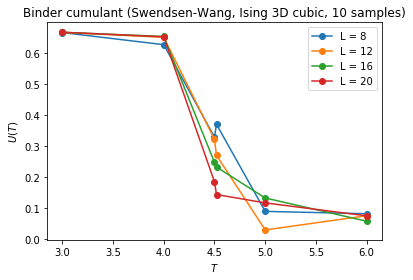

In [39]:
for L in L_range:
    binder_array = []
    chi_array = []
    m_array = []
    ene_array = []
    for T in T_range:
        result_mag = np.zeros((samples,))
        result_mag_2 = np.zeros_like(result_mag)
        result_mag_4 = np.zeros_like(result_mag)
        result_ene = np.zeros_like(result_mag)
        result_binder = np.zeros_like(result_mag)
        result_chi = np.zeros_like(result_mag)

        start = timeit.default_timer()

        for n in range(samples):
            simulation = SwendsenWang(T, L)
            mag_array, mag_2_array, mag_4_array, ene_array = simulation.run(thermalize, time_steps)
            result_mag[n] = np.mean(mag_array)
            result_mag_2[n] = np.mean(mag_2_array)
            result_mag_4[n] = np.mean(mag_4_array)
            result_ene[n] = np.mean(ene_array)
            result_binder[n] = 1 - result_mag_4[n] / (3 * result_mag_2[n]**2)
            result_chi[n] = 1 / T * L**3 * (result_mag_2[n] - result_mag[n]**2)
            
        end = timeit.default_timer()
        print(100 * '-')
        print('L = {}, T = {:.3f} : {:.3f}s simulation time for {} samples over {} total steps ({}*[{}+{}]) on {} sites'.format(L, T, end-start, samples, samples*(thermalize+time_steps), samples, thermalize, time_steps, L**3))
        print(100 * '=')
        binder_array.append(np.mean(result_binder))
        chi_array.append(np.mean(result_chi))
        m_array.append(np.mean(result_mag))
        ene_array.append(np.mean(result_ene))
        
    plt.plot(T_range, binder_array, 'o-', label='L = {}'.format(L))
plt.xlabel('$T$')
plt.ylabel('$U(T)$')
plt.title('Binder cumulant (Swendsen-Wang, Ising 3D cubic, {} samples)'.format(samples))
plt.legend()
plt.savefig('binder_cumulant.pdf', dpi=300)

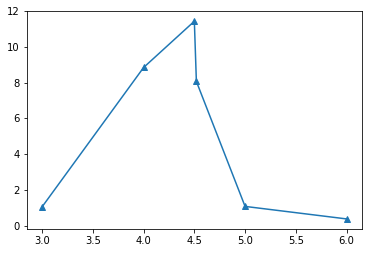

In [40]:
plt.plot(T_range, chi_array, '^-')

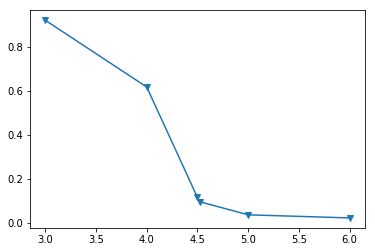

In [41]:
plt.plot(T_range, m_array, 'v-')